<hr style="border-width:2px;border-color:#0B39A4">
<center><h2> Segmentation of Cloudy Regions </h2></center>
<hr style="border-width:2px;border-color:#0B39A4">



### Introduction

>In this notebook, we provide a first analysis of the data set. We used some computer vision techniques to deeply understand the nature of the data and to take the right decision for which techniques to use later on. 

### 1. Definition of useful functions

In [2]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.patches as ptch
import plotly.express as px
import os

import cv2
from skimage import io, img_as_float 
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
def rle_decode(mask_rle: str = '', shape: tuple = (1400, 2100)):
    '''
    Decode rle encoded mask.
    
    :param mask_rle: run-length as string formatted (start length)
    :param shape: (height, width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    if not isinstance(mask_rle, np.float):
        s = mask_rle.split()
        starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
        starts -= 1
        ends = starts + lengths
        img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
        for lo, hi in zip(starts, ends):
            img[lo:hi] = 1
        return img.reshape(shape, order='F')

In [4]:
def rle_to_mask(rle_string, height, width):
    '''
    convert RLE(run length encoding) string to numpy array

    Parameters: 
    rle_string (str): string of rle encoded mask
    height (int): height of the mask
    width (int): width of the mask 

    Returns: 
    numpy.array: numpy array of the mask
    '''
    
    rows, cols = height, width
    
    if rle_string == -1:
        return np.zeros((height, width))
    else:
        rle_numbers = [int(num_string) for num_string in rle_string.split(' ')]
        rle_pairs = np.array(rle_numbers).reshape(-1,2)
        img = np.zeros(rows*cols, dtype=np.uint8)
        for index, length in rle_pairs:
            index -= 1
            img[index:index+length] = 255
        img = img.reshape(cols,rows)
        img = img.T
        return img

In [5]:
def get_mask_cloud(img_path, img_id, label, mask, df):
    img = cv2.imread(os.path.join(img_path, img_id), 0)
    new_df = df.loc[img_id]
    if isinstance(new_df[new_df['cloud_type']==label]['EncodedPixels'].iloc[0], np.ndarray):
        img = np.multiply(img, mask)
    else : 
        mask_decoded = rle_to_mask(mask, img.shape[0], img.shape[1])
        mask_decoded = (mask_decoded > 0.0).astype(int)
        img = np.multiply(img, mask_decoded)
    return img

In [6]:
def draw_all_labels(df_train_copy, train_image_path):
    samples_df_fish = df_train_copy[~(df_train_copy['EncodedPixels'].isna()) & (df_train_copy['cloud_type']=='Fish')].sample(3)
    samples_df_flower = df_train_copy[~(df_train_copy['EncodedPixels'].isna()) & (df_train_copy['cloud_type']=='Flower')].sample(3)
    samples_df_gravel = df_train_copy[~(df_train_copy['EncodedPixels'].isna()) & (df_train_copy['cloud_type']=='Gravel')].sample(3)
    samples_df_sugar = df_train_copy[~(df_train_copy['EncodedPixels'].isna()) & (df_train_copy['cloud_type']=='Sugar')].sample(3)
    count = 0
    count2 = 0
    fig, ax = plt.subplots(nrows=4, ncols=3, sharey=True, figsize=(20,20))
    for lab, title_form in zip([samples_df_fish, samples_df_flower, samples_df_gravel, samples_df_sugar], ['Fish', 'Flower', 'Gravel', 'Sugar']):
        for idx, sample in lab.iterrows():
            img = get_mask_cloud(train_image_path, sample['ImageId'], sample['cloud_type'],sample['EncodedPixels'], df_train_copy)
            ax[count2, count].imshow(img, cmap="gray")
            title_im = title_form + ' n=°' + str(count + 1)
            ax[count2, count].set_title(title_im)
            ax[count2, count].set_xticks([])
            ax[count2, count].set_yticks([])
            count += 1
        count2 += 1
        count = 0

In [7]:
def findMaskCenterX(mask):
    '''
    Compute the center of a mask and returns its coordinates
    '''
    thresh = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY)[1]
    M = cv2.moments(thresh, True)
    cX = int(M["m10"] / M["m00"])
    return cX

def findMaskCenterY(mask):
    '''
    Compute the center of a mask and returns its coordinates
    '''
    thresh = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY)[1]
    M = cv2.moments(thresh, True)
    cY = int(M["m01"] / M["m00"])
    return cY

def findMaskCenter(mask):
    '''
    Compute the center of a mask and returns its coordinates
    '''
    thresh = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY)[1]
    M = cv2.moments(thresh, True)
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    return [cX, cY]

In [8]:
def draw_masks(df_train_copy, id_image, train_image_path):
    samples_df = df_train_copy[df_train_copy['ImageId'] == id_image +'.jpg']
    count = 0
    fig, ax = plt.subplots(nrows=1, ncols=4, sharey=True, figsize=(20,10))
    for idx, sample in samples_df.iterrows():
        img = get_mask_cloud(train_image_path, sample['ImageId'], sample['cloud_type'],sample['EncodedPixels'], df_train_copy)
        ax[count].imshow(img, cmap="gray")
        ax[count].set_title(sample['cloud_type'])
        ax[count].set_xticks([])
        ax[count].set_yticks([])
        count += 1

In [9]:
def computeArea(mask):
    '''
    Compute the Area of a mask
    '''
    thresh = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY)[1]
    M = cv2.moments(thresh, True)
    return M['m00']

In [10]:
def displayImage(img_id, images_dir, df, dispMask = False, fig_size = (16,16)):
    image = cv2.imread(os.path.join(images_dir, img_id));
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB);
    print(img_id)
    plt.figure(figsize = (16,16))
    plt.imshow(image);
    
    if dispMask:
        
        # Récupérer la matrice du mask
        # S'il est disponible
        rows = df.loc[img_id]
        # Liste de couleurs pour les masks :
        # Fish - Jaune, Flower - Rose, Gravel - Rouge, Sugar - Vert
        l_colors = [(255, 255, 5),  (119, 51, 255) , (10, 246, 203), (5, 155, 39)]
        for index, row in enumerate(rows.iterrows()):
            try:
                try:
                    mask = rle_decode(row[1][1])
                except:
                    mask = row[1][1]
                # Conversion en couleur
                mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
                mask[np.all(mask!=(0,0,0), axis=2), :] = l_colors[index]
                plt.imshow(mask, alpha = 0.25, cmap = 'gray')
                #print("ok")
                
            except:
                mask = np.ones_like(image)*255
                
        # Legend
        scale = 255
        f = [[x/scale for x in color] for color in l_colors]
        elements = [ptch.Patch(facecolor= f[0], label='Fish', alpha = None), 
                ptch.Patch(facecolor= f[1], label='Flower', alpha = None), 
                ptch.Patch(facecolor= f[2],  label='Gravel', alpha = None), 
                ptch.Patch(facecolor= f[3],  label='Sugar', alpha = None)]
        plt.legend(handles= elements, loc = 'best')
        plt.xticks([])
        plt.yticks([])
        #plt.savefig('/content/drive/My Drive/PROJET DS/DataViz/viz_'+ img_id)
        #return rows, f

### 2. Train Dataset Loading


In [4]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
path = '/content/drive/MyDrive/LoopyClouds'
train_imgs_folder = '/content/drive/MyDrive/LoopyClouds/train_images'


path_train = os.path.join('r', path, 'train.csv')
df_train = pd.read_csv(path_train)
df_train['id_image'] = df_train['Image_Label'].apply(lambda row: row.split('_')[0])
df_train['cloud_type'] = df_train['Image_Label'].apply(lambda row: row.split('_')[1])
df_train = df_train.set_index('id_image')
df_train['ImageId'] = df_train['Image_Label'].apply(lambda row: row.split('_')[0])
train = df_train.dropna()
train.drop(['Image_Label'], axis = 1, inplace = True)
train.reset_index(inplace=True)
train.head()

,id_image,EncodedPixels,cloud_type,ImageId
0,0011165.jpg,264918 937 266318 937 267718 937 269118 937 27...,Fish,0011165.jpg
1,0011165.jpg,1355565 1002 1356965 1002 1358365 1002 1359765...,Flower,0011165.jpg
2,002be4f.jpg,233813 878 235213 878 236613 878 238010 881 23...,Fish,002be4f.jpg
3,002be4f.jpg,1339279 519 1340679 519 1342079 519 1343479 51...,Flower,002be4f.jpg
4,002be4f.jpg,67495 350 68895 350 70295 350 71695 350 73095 ...,Sugar,002be4f.jpg


### 3. Quick Data analysis


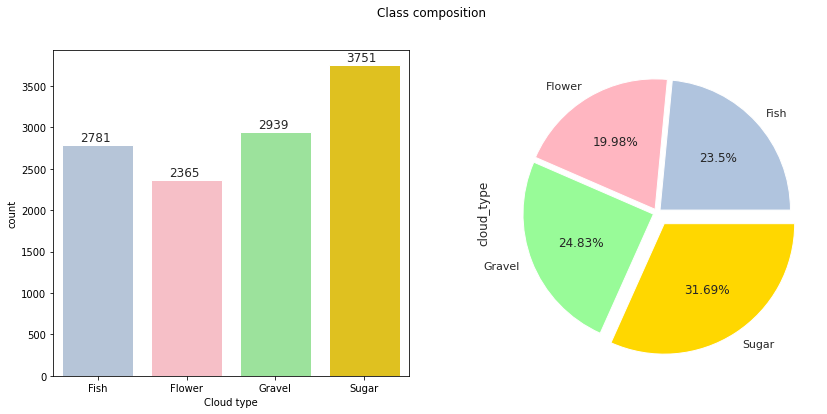

In [14]:
plt.figure(figsize = (14, 6))

plt.suptitle('Class composition')

plt.subplot(1, 2, 1)

sns.set();
ax=sns.countplot(x = train['cloud_type'].sort_values(), 
                 palette =['lightsteelblue','lightpink','lightgreen','gold'])

ax.set(xlabel='Cloud type')

for p in ax.patches:
        ax.annotate('{}'.format(p.get_height()), 
                    (p.get_x()+0.2, p.get_height()+50))

plt.subplot(1, 2, 2)

train['cloud_type'].value_counts(normalize=True).sort_index().plot(kind='pie', 
                                                 colors=['lightsteelblue','lightpink','palegreen','gold'], 
                                                 explode = [0.03, 0.03, 0.03, 0.1],
                                                 autopct = lambda x : str(round(x, 2)) + '%')

plt.show()


<div class="alert alert-info">
The dataset is quite balanced, although the Sugar class is a little bit overrepresented. 
</div>



<center><h1> 
### 4. Cloud image analysis
<hr style="border-width:2px;border-color:#0B39A4">
</h1></center> 

> It is now time to display some photos and masks to better understand the meaning of the different classes. We have chosen to display three examples for each class in order to get an overall idea of the shapes of the different formations.

>The images below represent the formations identified by their masks. 

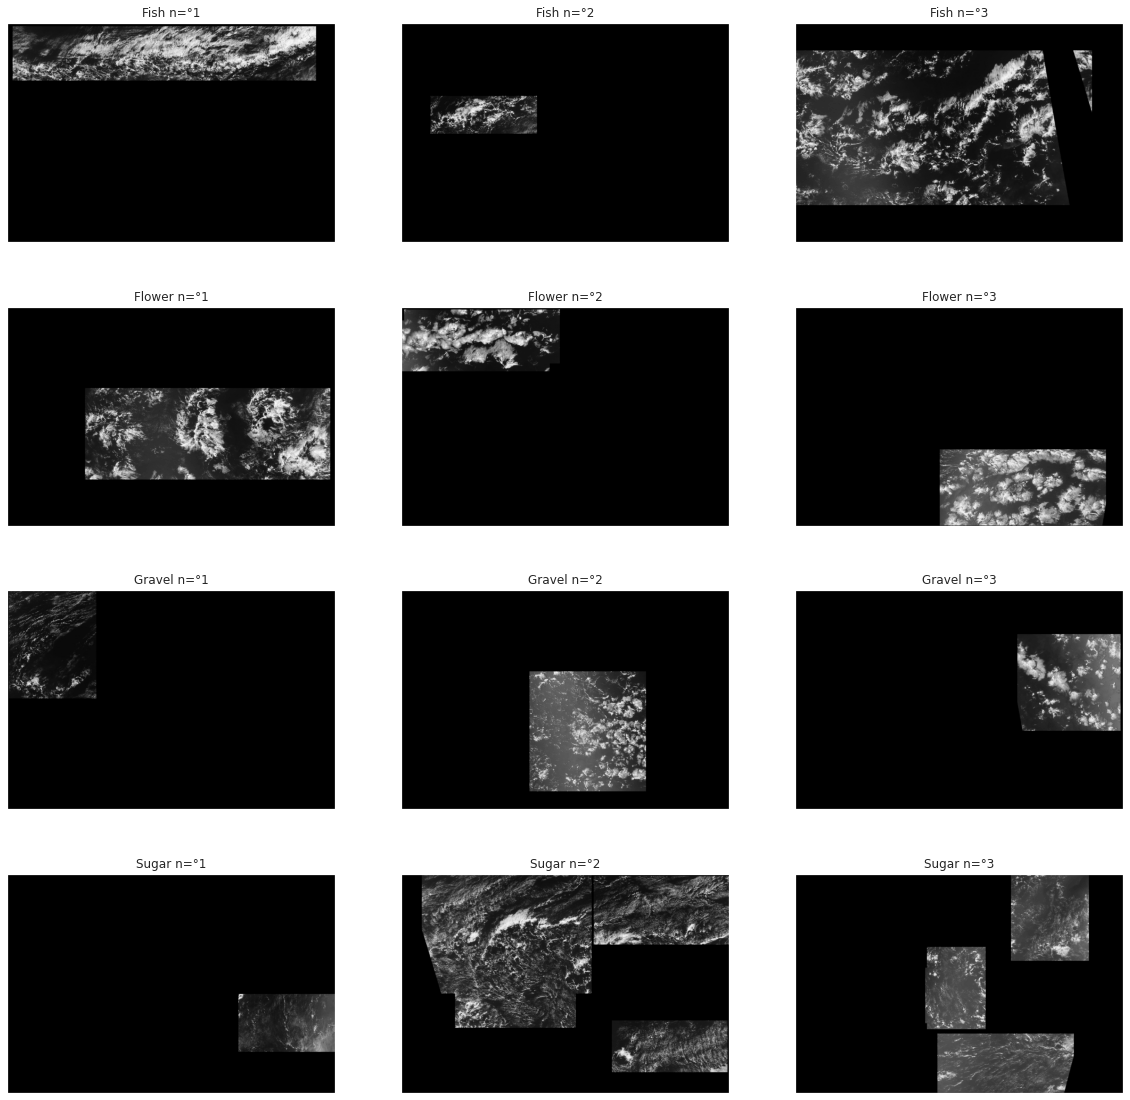

In [30]:
draw_all_labels(df_train_copy = df_train,train_image_path = train_imgs_folder)

> One picture can contain more than one cloud formation. Thus, there can be several classes on one picture, or even different clouds representing the same class. 

In [ ]:
df_train['EncodedPixels'] = df_train['EncodedPixels'].apply(rle_decode)

043e76c.jpg


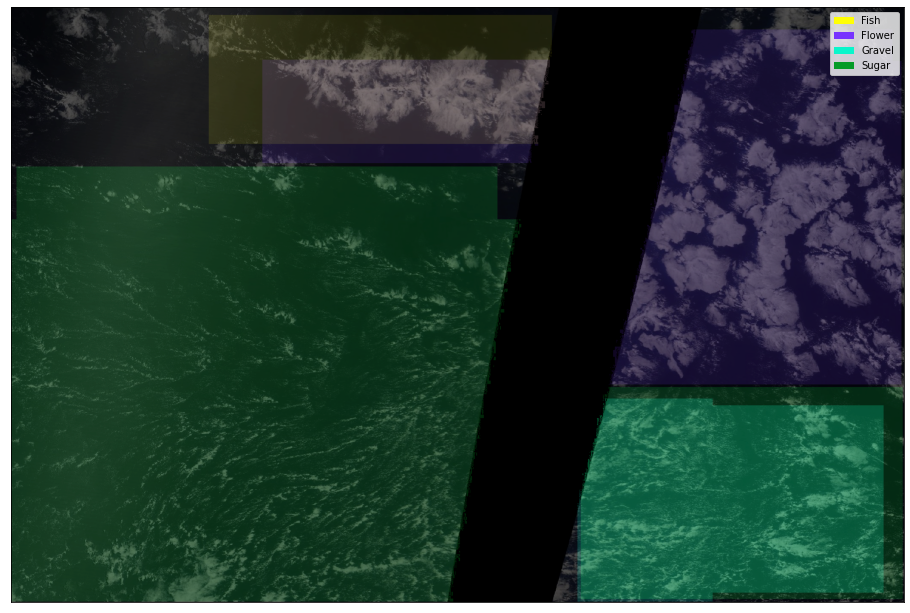

In [ ]:
df_image_dviz = (df_train.loc['043e76c.jpg'])
displayImage('043e76c.jpg', path_train_images, df_image_dviz, True, (8,8));


It is interesting to note that masks can overlap. As a reminder, the determination of the masks is carried out by a panel of scientists (at least 3 different ones per image). This means that the interpretation of a formation can be different according to each scientist, which risks complicating our analysis. There will therefore be a reflection to be had on this type of data for the continuation of this project, in particular their impact on the performance of the model. 


> We can even print the classes in separated images

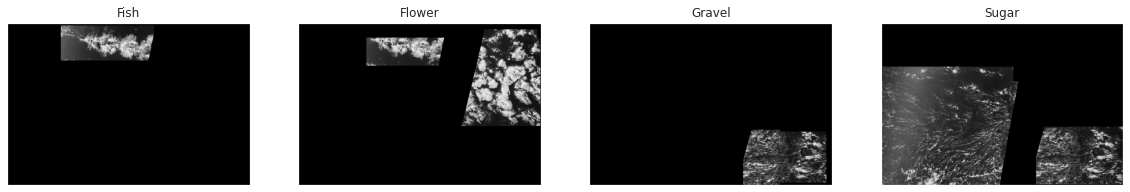

In [18]:
draw_masks(df_train, '043e76c', train_imgs_folder)


## 5. Average image study 

In a computer vision problem, it can be interesting to see the average images of the classes.

In [14]:
df_train_fish = df_train[(df_train['cloud_type'] == 'Fish') & (df_train['EncodedPixels'].isna() == False)]
df_train_flower = df_train[(df_train['cloud_type'] == 'Flower')  & (df_train['EncodedPixels'].isna() == False)]
df_train_gravel = df_train[(df_train['cloud_type'] == 'Gravel')  & (df_train['EncodedPixels'].isna() == False)]
df_train_sugar = df_train[(df_train['cloud_type'] == 'Sugar')  & (df_train['EncodedPixels'].isna() == False)]

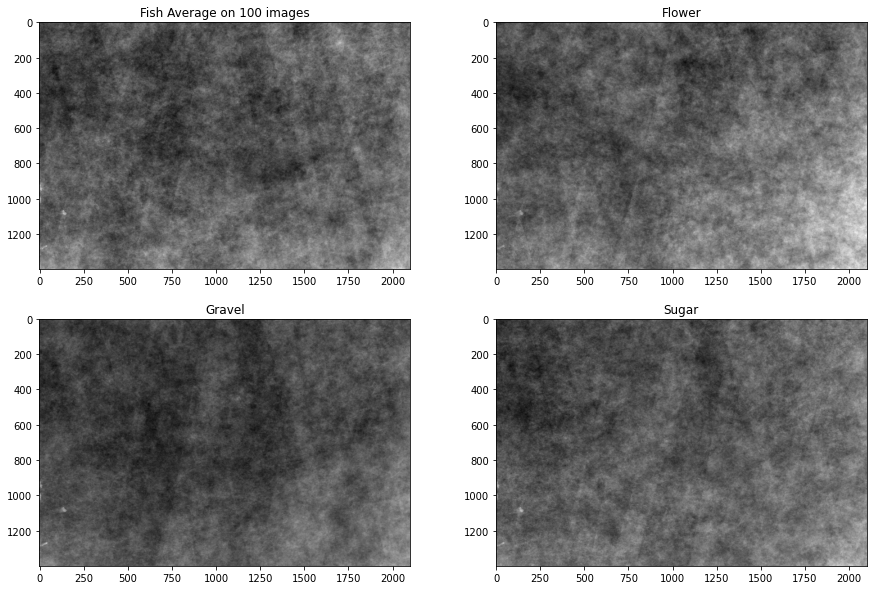

In [15]:
image_Sugar = []
image_Gravel = []
image_Flower = []
image_Fish = []

def Mean_photo(df, liste):
    for row in df['ImageId'].iloc[:100]:
        path_image = train_imgs_folder+ '/' + row
        #print(path_image)
        image2 = cv2.imread(path_image, cv2.IMREAD_GRAYSCALE) 
        #image2 = cv2.resize(image,None,fx=0.75,fy=0.75)
        liste.append(image2)
    return liste
    
mean_fish = np.mean(Mean_photo(df_train_fish, image_Fish), axis = 0)
mean_flower = np.mean(Mean_photo(df_train_flower, image_Flower), axis = 0)
mean_gravel = np.mean(Mean_photo(df_train_gravel, image_Gravel), axis = 0)
mean_sugar = np.mean(Mean_photo(df_train_sugar, image_Sugar), axis = 0)

plt.figure(figsize = (15, 10))

plt.subplot(2, 2, 1)
plt.imshow(mean_fish, cmap = 'gray')
plt.title("Fish Average on 100 images")
plt.subplot(2, 2, 2)
plt.imshow(mean_flower, cmap = 'gray')
plt.title("Flower")
plt.subplot(2, 2, 3)
plt.imshow(mean_gravel, cmap = 'gray')
plt.title("Gravel")
plt.subplot(2, 2, 4)
plt.imshow(mean_sugar, cmap = 'gray')
plt.title("Sugar");

<div class="alert alert-info">
We can observe very similar average images for all the training courses. There is therefore no clear "typical profile" of each class. It would therefore be complicated to envisage a segmentation "by hand" using classic computer vision tools. 
To be convinced of this, let us continue our image analysis in more detail. 
</div>

## 6.Chromatic Analysis 

> Let's visualise the chromatic signature of a cloud image by plotting on a three-dimensional point cloud the value of the pixels on the 3 channels RGB.  

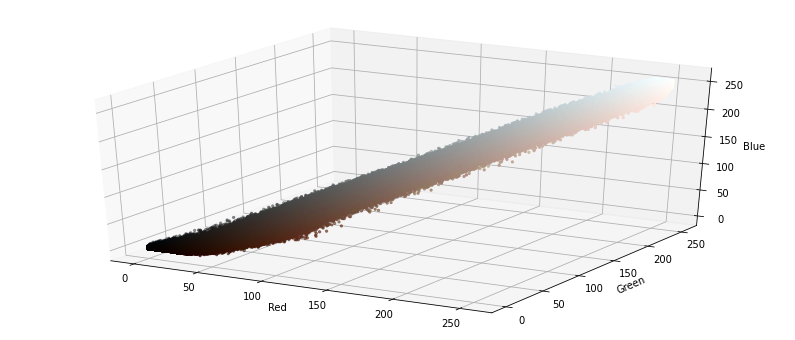

In [15]:
from matplotlib import colors

#We pick a random image of the dataset 

n = np.random.randint(0, len(train)-1)
image = cv2.imread(os.path.join(train_imgs_folder, df_train.index.values[n]))

#


r, g, b = cv2.split(image)

fig = plt.figure(figsize = (14, 6))

axis = fig.add_subplot(1, 1, 1, projection="3d")

#flattening the image and Projection of each vector along the axes 
pixel_colors = image.reshape((np.shape(image)[0]*np.shape(image)[1], 3))

norm = colors.Normalize(vmin=-1.,vmax=1.)
norm.autoscale(pixel_colors)

pixel_colors = norm(pixel_colors).tolist()

axis.scatter(r.flatten(), 
             g.flatten(), 
             b.flatten(), 
             facecolors=pixel_colors, 
             marker=".")

axis.set_xlabel("Red")
axis.set_ylabel("Green")
axis.set_zlabel("Blue")

plt.show()

>We observe a very uniform colour range that produces a longitudinal blue > gradient shape on the projection space. It is very likely that a greyscale conversion will have a negligible impact on the information in the image and on the understanding that a classification algorithm can make of it. 
We will now to explore different greyscale conversion options, first on an histogram. We won't take into account black pixels in the image, which are accounting for the black bands on it. 


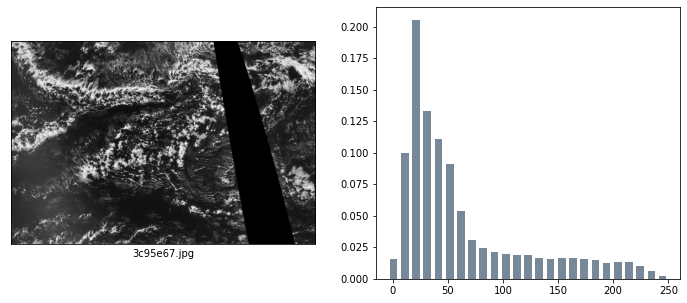

In [23]:

image = cv2.imread(os.path.join(train_imgs_folder, df_train.index.values[n]))
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

fig, ax = plt.subplots(1,2,figsize=(12,5))

ax[0].imshow(image_gray,cmap = 'gray')

ax[0].set_xticks([])
ax[0].set_yticks([])

ax[0].set_xlabel(df_train.index[n])

# Getting rid of black pixels 
hist = np.histogram(image_gray,
                     bins=25,
                     range = (1,255)) 
plt.bar(hist[1][:-1],
        hist[0]/np.sum(hist[0]),
        width=7, color = 'lightslategrey')

plt.show()

Let's now study the conversion into binary black and white image, with different thresholds

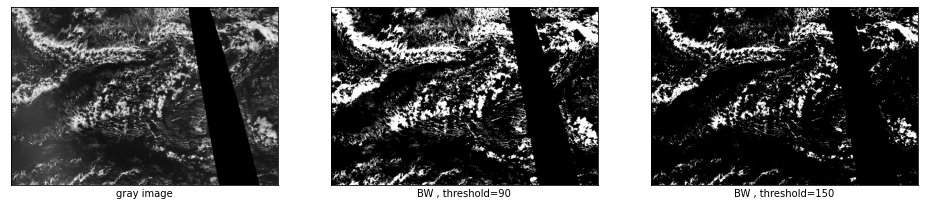

In [26]:
plt.figure(figsize = (22,15))

plt.subplot(1, 4, 1)

plt.imshow(image_gray, 
           cmap = 'gray')

plt.xticks([])
plt.yticks([])

plt.xlabel("gray image")

thresholds = [90,150]

k = 2

for s in thresholds:
    (thresh, BWImage) = cv2.threshold(image_gray, 
                                               s, 
                                               255, 
                                               cv2.THRESH_BINARY)

    plt.subplot(1, 4, k)

    plt.imshow(BWImage, 
             cmap = 'gray')

    plt.xticks([])
    plt.yticks([])

    plt.xlabel("BW , threshold="+str(s))
    k += 1

plt.show()



The switch to black and white would perhaps bring added value in the elimination of superfluous information or at least information that would not add anything to the model. This point will have to be verified when developing a model. The 90 threshold is the one for which there are the less information loss. Moreover, the gray image has the same amount of information as the colorized image. This could enable us to increase the quality of images without making the dataset heavier. 

<center><h1> 
Conclusion
<hr style="border-width:2px;border-color:#0B39A4">
</h1></center> 
 
A few important points appear through this data analysis: 
- Several formations can be present in each image and each image has at least one formation,
- The same formation in an image can be interpreted in different ways by different people, 
- Two different and distinct formations can be contained in the same mask,
- The formations are uniformly distributed across the images,
- There is no typical image according to the formation.
- The images are convertible into the Black and white format, and given their Gray profile, they are mainly dark. 